# Testing a simple peakbag

I need to obtain some preliminary results for TASC5, so I'm going to run a simplified peakbagging code with fewer bells and whistles.

- I will divide out the background best fit in advance
- I will not impose a complex prior on linewidth
- I will not apply a smoothness condition
- I will not impose a complex prior on mode heights

The expected effect of this will be, in order:

- Reduced quality inference on mode location
- Increased uncertainty on linewidths
- Risk of mode flipping on the $l = 0, 2$ pairs
- Increased runtime as the mode heights are less constrained

All these issues will be fixed before final publication and highlighted as caveats in the poster.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

In [2]:
target = '16cyga'

In [3]:
def harvey(f, a, b, c):
    harvey = 0.9*a**2/b/(1.0 + (f/b)**c);
    return harvey

def get_apodization(freqs, nyquist):
    x = (np.pi * freqs) / (2 * nyquist)
    return (np.sin(x)/x)**2

def get_background(f, a, b, c, d, j, k, white, numax, scale, nyq):
    background = np.zeros(len(f))
    background += get_apodization(f, nyq) * scale\
                    * (harvey(f, a, b, 4.) + harvey(f, c, d, 4.) + harvey(f, j, k, 2.))\
                    + white
    return background

Lets read in the modes

In [4]:
if target == 'sim':
    locs = np.genfromtxt('../scripts/locs.txt')
    mid = int(np.floor(len(locs)/2))
    l0s = locs[mid:mid+2,0]
    l1s = locs[mid:mid+2,1]
    l2s = locs[mid-1:mid+1,2]

    modelocs = np.array([l0s, l1s, l2s]).flatten()
    modeids = [0]*len(l0s)  + [1]*len(l1s) + [2]*len(l2s)

    ff = np.genfromtxt('../scripts/freqs.txt')
    pp = np.genfromtxt('../scripts/model.txt')
    sel = [(ff >= np.min(modelocs)-10) & (ff <= np.max(modelocs+10))]
    f = ff[tuple(sel)]
    pf = pp[tuple(sel)] 

    with open('backfit_sim.pkl', 'rb') as file:
        backfit = pickle.load(file)

if target == '16cyga':
    mal = pd.read_csv('../../data/malatium.csv', index_col=0)
    star = mal.loc[62]
    kic = star.KIC
    numax = star.numax
    dnu = star.dnu

    # Get the power spectrum
    # Col1 = frequency in microHz, Col2 = psd
    sfile = glob.glob('../../data/*{}*.pow'.format(kic))
    data = ascii.read(sfile[0]).to_pandas()

    # Read in the mode locs
    
    cop = pd.read_csv('../../data/copper.csv',index_col=0)
    modelocs = cop[cop.KIC == str(kic)].Freq.values[26:28]
    elocs = cop[cop.KIC == str(kic)].e_Freq.values[26:28]
    n = cop[cop.KIC == str(kic)].n.values[26:28]
    modeids = cop[cop.KIC == str(kic)].l.values[26:28]

    lo = modelocs.min() - .1*dnu
    hi = modelocs.max() + .1*dnu

    # Make the frequency range selection
    ff, pp = data['col1'],data['col2']
    sel = (ff > lo) & (ff < hi)
    f = ff[sel].values
    pf = pp[sel].values    

    backdir = glob.glob('/home/oliver/PhD/mnt/RDS/malatium/backfit/'
                        +str(kic)+'/*_fit.pkl')[0]
    with open(backdir, 'rb') as file:
        backfit = pickle.load(file)

In [5]:
labels=['loga','logb','logc','logd','logj','logk','lognumax','white','nyq','scale']
pr_phi = np.array([np.median(backfit[label]) for label in labels])
bf = pd.DataFrame(backfit)[labels]
res = np.array([np.median(bf[label]) for label in labels])
res[0:6] = 10**res[0:6]
bgmodel = get_background(f, *res)

p = pf / bgmodel

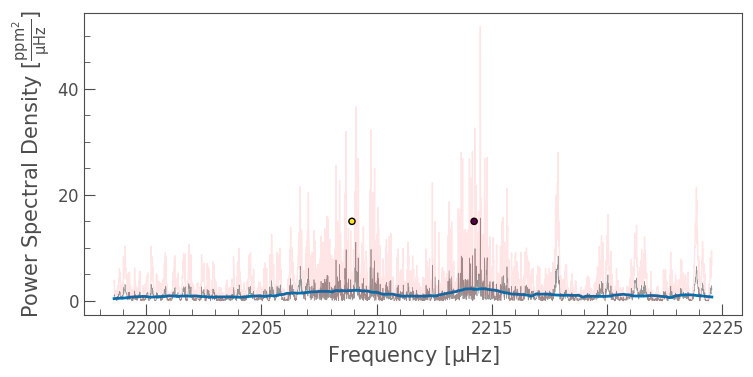

In [6]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
ax.plot(f, pf, alpha=.1, c='r', lw=1.)
plt.show()

In [7]:
overwrite = False
pb_simple = '''
functions{      
    vector lorentzian(real loc, int l, int m, vector f, real eps, real H, real w, real nus){
        return (eps * H) ./ (1 + (4/w^2) * square(f - loc + m*nus));
    }
}
data{
    int N;                   // Number of data points
    int M;                   // Number of modes
    vector[N] f;             // Frequency
    vector[N] p;             // Power
    real pr_locs[M];         // Mode locations (this will have to change for multiple n modes)
    real e_locs[M];          // Uncertainty on the mode locations
    int ids[M];              // The ID's of the modes
}
parameters{
    real logAmp[M];          // Mode amplitude in log space
    real logGamma[M];        // Mode linewidth in log space
    real locs[M];            // True mode locations
    real<lower=0> vsini;     //  Sin of angle of inclination x rotational splitting
    real<lower=0> vcosi;     //  Cos of angle of inclination x rotational splitting
    real<lower=0> b;        // The background parameters
}
transformed parameters{
    real H[M];                             // Mode height
    real w[M];                             // Mode linewidth
    real i;                                // Angle of inclination (rad)
    real<lower=0> nus;                     // Rotational frequency splitting   
    
    nus = sqrt(vsini^2 + vcosi^2);         //Calculate the splitting
    i = acos(vcosi / nus);                 // Calculate the inclination
    
    for (m in 1:M){
        w[m] = 10^logGamma[m];             // Transform log linewidth to linewidth    
        H[m] = 10^logAmp[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
}
model{
    vector[N] modes;             // Our Model
    matrix[4,4] eps;             // Matrix of legendre polynomials
    int l;                       // The radial degree
    real nus_mu = 0.5;           // Circumventing a Stan problem
    
    eps = rep_matrix(1., 4, 4);  // Calculate all the legendre polynomials for this i
    eps[0+1,0+1] = 1.;
    eps[1+1,0+1] = cos(i)^2;
    eps[1+1,1+1] = 0.5 * sin(i)^2;
    eps[2+1,0+1] = 0.25 * (3. * cos(i)^2 - 1.)^2;
    eps[2+1,1+1] = (3./8.)*sin(2*i)^2;
    eps[2+1,2+1] = (3./8.) * sin(i)^4;
    eps[3+1,0+1] = (1./64.)*(5.*cos(3.*i) + 3.*cos(i))^2;
    eps[3+1,1+1] = (3./64.)*(5.*cos(2.*i) + 3.)^2 * sin(i)^2;
    eps[3+1,2+1] = (15./8.)*cos(i)^2 * sin(i)^4;
    eps[3+1,3+1] = (5./16.)*sin(i)^6;    

        
    // Generating our model
    modes = rep_vector(b, N);
    for (mode in 1:M){        // Iterate over all modes passed in
        l = ids[mode];        // Identify the Mode ID
        for (m in -l:l){      // Iterate over all m in a given l
            modes += lorentzian(locs[mode], l, m, f, eps[l+1,abs(m)+1], H[mode], w[mode], nus);
        }
    }

    // Model drawn from a gamma distribution scaled to the model (Anderson+1990)
    p ~ gamma(1., 1../modes);
    
    //priors on the parameters
    logAmp ~ normal(1.5, 1.);
    logGamma ~ normal(0., .2);
    locs ~ normal(pr_locs, e_locs);
    nus_mu ~ normal(nus, 1.);
    vsini ~ uniform(0,nus);
       
    b ~ lognormal(1., 1.);
}
'''
model_path = 'pb_simple.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = pb_simple, model_name='pb_simple')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()
if os.path.isfile(model_path):
    print('Reading in Stan model')
    sm = pickle.load(open(model_path, 'rb'))
else:
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = pb_simple, model_name='pb_simple')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()

Reading in Stan model


Now lets try and read in the backfit output...

In [8]:
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
dnu = 102. #uHz
d02 = 6.2 #uHz

data = {'N':len(f),
        'M': len(modelocs),
        'f':f,
        'p':p,
        'pr_locs':modelocs,
        'e_locs':np.ones(len(modelocs))*0.36,
        'ids':modeids}

init = {'logAmp' :   np.ones(len(modelocs))*1.5,
        'logGamma': np.zeros(len(modelocs)),
        'vsini' : nus*np.sin(i),
        'vcosi' : nus*np.cos(i),
        'i' : i,
        'nus': nus,
        'locs' : modelocs,
        'b': 1.}

In [9]:
nchains = 4
fit = sm.sampling(data=data, iter=1000, chains=nchains, seed=11,
                  init = [init for n in range(nchains)])

In [10]:
print(fit)

Inference for Stan model: pb_simple_aac09d5b1451a46f2aa7976130db9758.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logAmp[1]      0.9  1.4e-3   0.05    0.8   0.87    0.9   0.94    1.0   1301    1.0
logAmp[2]     0.91  1.5e-3   0.06    0.8   0.87   0.91   0.94   1.02   1423    1.0
logGamma[1]   -0.3  6.6e-3   0.13  -0.53   -0.4  -0.32  -0.22-3.5e-3    420   1.01
logGamma[2]   0.04  1.9e-3   0.08  -0.12  -0.01   0.04    0.1   0.21   1906    1.0
locs[1]     2208.3  5.6e-3   0.08 2208.1 2208.3 2208.3 2208.4 2208.4    211   1.01
locs[2]     2214.3  1.9e-3   0.08 2214.2 2214.3 2214.3 2214.4 2214.5   1809    1.0
vsini         0.67  2.5e-3   0.05   0.55   0.65   0.67    0.7   0.74    327   1.01
vcosi         0.29  4.4e-3   0.09   0.13   0.25   0.28   0.31   0.48    443   1.01
b             0.89  6.7e-4   0.03   0.84   0.87   0.89   0.91   0.9

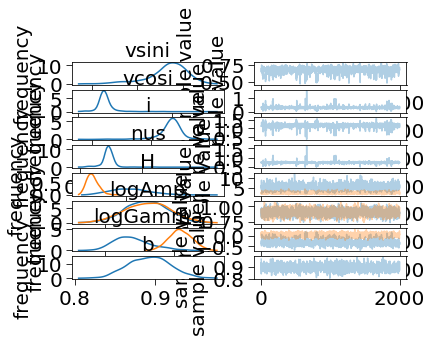

In [11]:
fit.plot(pars=['vsini','vcosi','i','nus','H','logAmp','logGamma','b'])
plt.show()

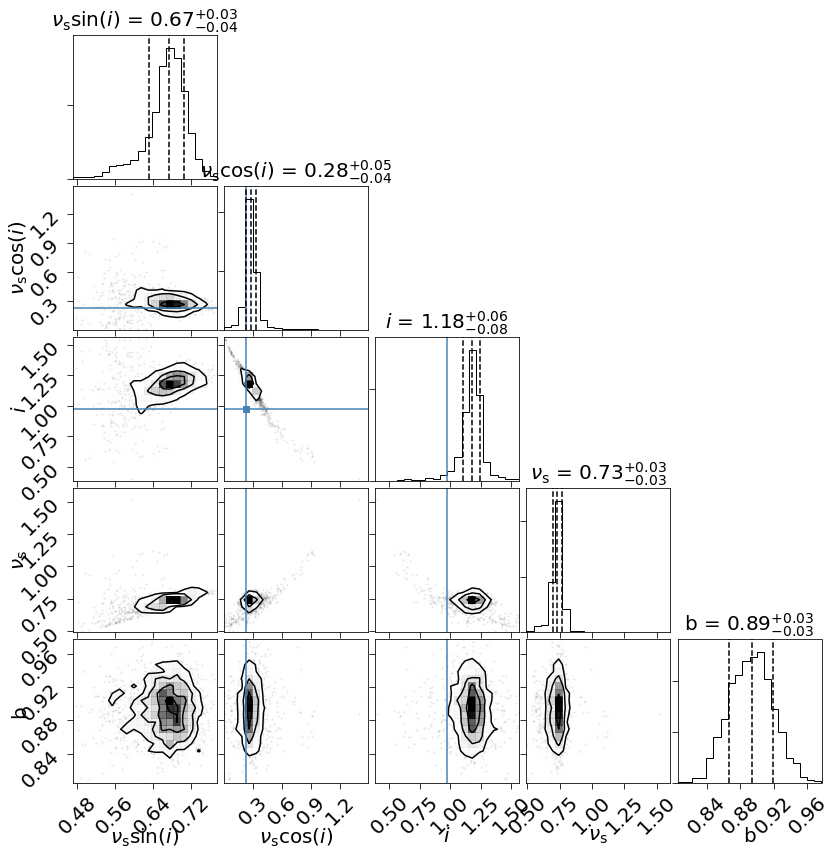

l = 2


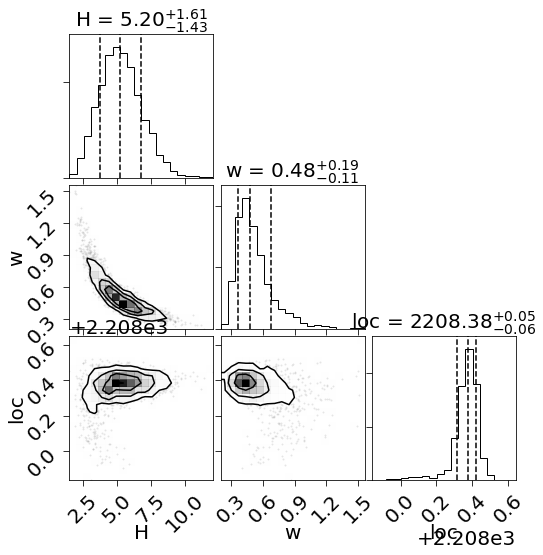

l = 0


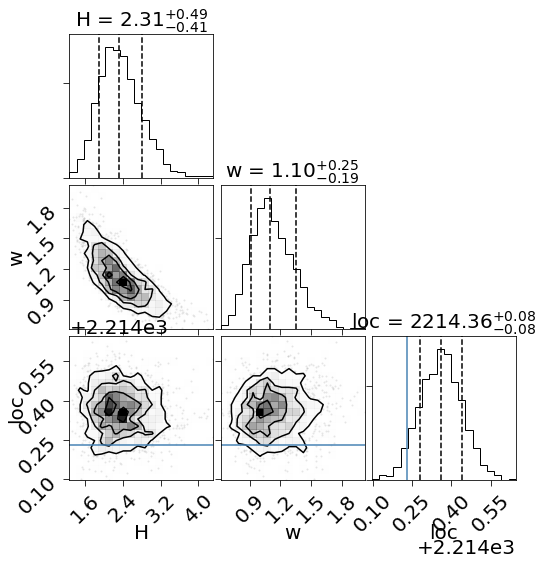

In [12]:
truths= [init['vsini'],init['vcosi'],init['i'],init['nus'], 1.]
labels=['vsini','vcosi','i','nus', 'b']
chain = np.array([fit[label] for label in labels])
verbose = [r'$\nu_{\rm s}\sin(i)$',r'$\nu_{\rm s}\cos(i)$',r'$i$',
            r'$\nu_{\rm s}$', r'b']
corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84],
            truths=truths,show_titles=True)
plt.show()

for idx in range(len(fit['H'].T)):
    truths = [np.nan, np.nan, data['pr_locs'][idx]]
    chain = np.array([fit['H'].T[idx], fit['w'].T[idx], fit['locs'].T[idx]])
    corner.corner(chain.T, labels=['H','w', 'loc'], truths=truths,
                  quantiles=[0.16, 0.5, 0.84],show_titles=True)
    print('l = {}'.format(modeids[idx]))   
    plt.show()

In [13]:
def get_epsilon(i, l, m):
#I use the prescriptions from Gizon & Solank 2003 and Handberg & Campante 2012
    if l == 0:
        return 1
    if l == 1:
        if m == 0:
            return np.cos(i)**2
        if np.abs(m) == 1:
            return 0.5 * np.sin(i)**2
    if l == 2:
        if m == 0:
            return 0.25 * (3 * np.cos(i)**2 - 1)**2
        if np.abs(m) ==1:
            return (3/8)*np.sin(2*i)**2
        if np.abs(m) == 2:
            return (3/8) * np.sin(i)**4
    if l == 3:
        if m == 0:
            return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
        if np.abs(m) == 1:
            return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
        if np.abs(m) == 2:
            return (15/8) * np.cos(i)**2 * np.sin(i)**4
        if np.abs(m) == 3:
            return (5/16)*np.sin(i)**6
    
def lorentzian(f, l, m, loc, i, H, w, nus):
    eps = get_epsilon(i,l,m)
    model = eps * H / (1 + (4/w**2)*(f - loc + m * nus)**2)
    return model

model = np.ones(len(f))
nus = np.median(fit['nus'])
for mode in range(len(modeids)):
    l = modeids[mode]
    for m in range(-l, l+1):
        loc = np.median(fit['locs'].T[mode])
        H = np.median(fit['H'].T[mode])
        w = np.median(fit['w'].T[mode])
        model += lorentzian(f, l, m, loc, i, H, w, nus)
fitlocs = np.median(fit['locs'],axis=0)

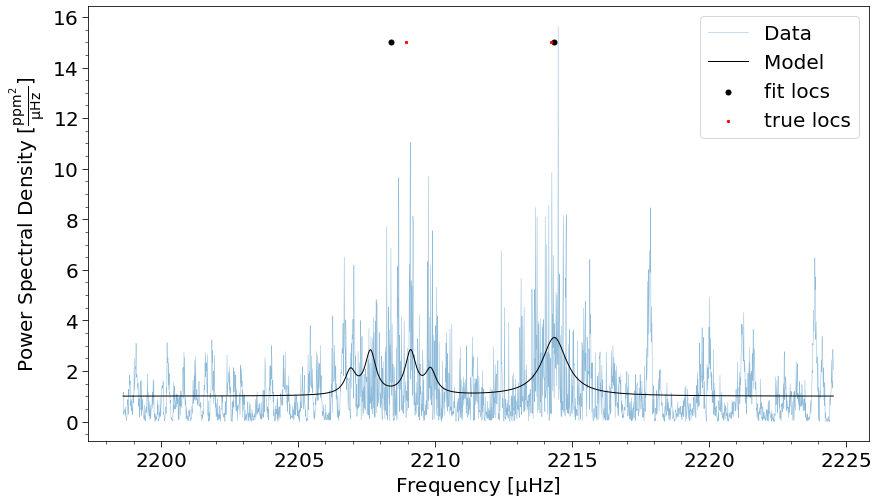

In [14]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
fig, ax = plt.subplots(figsize=(14,8))
pg.plot(alpha=.5, label='Data',ax=ax)
plt.scatter(fitlocs, [15]*len(fitlocs),c='k',s=25, label='fit locs')
plt.scatter(modelocs, [15]*len(modelocs),c='r',s=5, label='true locs')
plt.plot(f, model, linewidth=1, label='Model',c='k')
plt.legend()

In [15]:
fs = np.median(np.diff(f))
1./(fs*1e-6) / 60 / 60 / 24

1051.570831439504

In [16]:
import sys
sys.exit()

SystemExit: 

/home/oliver/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
print('The length of the dataset: {} years'.format(1e6/np.median(np.diff(f)) / 60 / 60 / 24 / 365))
print('We ran using: {} modes'.format(len(modelocs)))
time = 2747.62
print('It took {} seconds == {} hours'.format(time, np.round(time/60/60,2)))